In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

Per the course AI usage policy, I must say that I relied on chatgpt for help with processing the data from these unfamiliar files. However, I've taken lots of time to understand the process and adapt or build on much of the code to my own needs, so the comments should reflect this and make it easy to read. 

I found the dataset takes ~5 minutes or less to read through and make into useable training and testing data

In [ ]:
# Only include chords that are major or minor (ignores maj7, dim, aug, sus, etc.)
VALID_QUALITIES = ['maj', 'min']

# Notes that have multiple names are mapped to only one name
ENHARMONIC_EQUIVS = {
    'B#': 'C', 
    'C#': 'Db',
    'D#': 'Eb',
    'Fb': 'E',
    'E#': 'F', 
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
    'Cb': 'B',
}

# Initialize lists to store mean chroma features over time (X) and chord labels (y)
X = []
y = []

# Define folder where the dataset is stored
data_path = "data/mcgill-billboard"

# Find paths to chord annotations and chroma metadata folders
annotation_dir = os.path.join(data_path, "annotations", "annotations")
metadata_dir = os.path.join(data_path, "metadata", "metadata")

# Make a list of every annotated track folder (one folder per track, e.g. 0003)
track_list = os.listdir(annotation_dir)

# Loop through every track folder in the annotation directory 
for track_id in tqdm(track_list):  # tqdm shows progress bar
    try:
        # Paths to the annotation and chroma data for this track
        lab_path = os.path.join(annotation_dir, track_id, "majmin.lab")
        chroma_path = os.path.join(metadata_dir, track_id, "bothchroma.csv")

        # If either file is missing, skip this track
        if not os.path.exists(lab_path) or not os.path.exists(chroma_path):
            continue

        # Read chroma CSV into a DataFrame
        df = pd.read_csv(chroma_path, header=None)

        # Drop any rows with NaN values
        df.dropna()

        # Name the columns: first 3 are metadata (audio path, time, duration)
        # The rest are assumed to be chroma values, named chroma_0 to chroma_11
        df.columns = ["audio_path", "time", "duration"] + [f"chroma_{i}" for i in range(df.shape[1] - 3)]

        # Open and read each line from the chord label file
        with open(lab_path, "r") as f:
            for line in f:
                # Split line into start time, end time, and label e.g., "0.000 1.500 C:maj"
                parts = line.strip().split()
                if len(parts) != 3:
                    continue  # skip malformed lines, should only have 3 parts

                start, end, label = parts

                # Skip labels that don’t include “:” (like "N" or malformed entries)
                if ':' not in label:
                    continue

                # Split chord quality from root (e.g., "C:maj" → "C", "maj"), then check if valid
                root, quality = label.split(':', 1)
                
                if quality not in VALID_QUALITIES:
                    continue

                #If root is an enharmonically equivalent note, convert it
                if root in ENHARMONIC_EQUIVS:
                    root = ENHARMONIC_EQUIVS[root]

                # Convert start and end times to float from strings
                start = float(start)
                end = float(end)

                # Select only chroma rows whose timestamps fall within the current chord segment
                segment = df[(df["time"] >= start) & (df["time"] < end)]

                # If no chroma rows are found for this time range, skip it
                if len(segment) == 0:
                    continue

                # Define the 12 chroma pitch class columns (C, C#, ..., B as chroma_0 to chroma_11)
                chroma_cols = [f"chroma_{i}" for i in range(12)]

                # Compute the mean chroma across the selected time range
                chroma_mean = segment[chroma_cols].mean().values

                X.append(chroma_mean)
                y.append(root + quality)  # full label, e.g., "Cmaj"

    except Exception as e:
        # Print the error if something goes wrong with this track
        print(f"Error with track {track_id}: {e}")

100%|██████████| 890/890 [02:27<00:00,  6.05it/s]


### Split Data

In [11]:
X = np.array(X)
y = np.array(y)

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model - Random Forest

In [12]:
# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

      A#:maj       0.81      0.84      0.83      1186
      A#:min       0.94      0.65      0.76       189
       A:maj       0.72      0.85      0.78      1985
       A:min       0.77      0.52      0.62       764
      B#:maj       0.79      0.86      0.82      2186
      B#:min       0.82      0.44      0.58       358
      C#:maj       0.77      0.78      0.78       647
      C#:min       0.84      0.76      0.80       315
      Cb:maj       0.79      0.79      0.79       901
      Cb:min       0.77      0.72      0.75       618
      D#:maj       0.79      0.84      0.81       793
      D#:min       0.83      0.64      0.72       306
       D:maj       0.78      0.84      0.81      2162
       D:min       0.79      0.55      0.65       722
      E#:maj       0.80      0.85      0.82      1614
      E#:min       0.78      0.75      0.76       315
      F#:maj       0.82      0.79

### Confusion Matrix - Random Forest

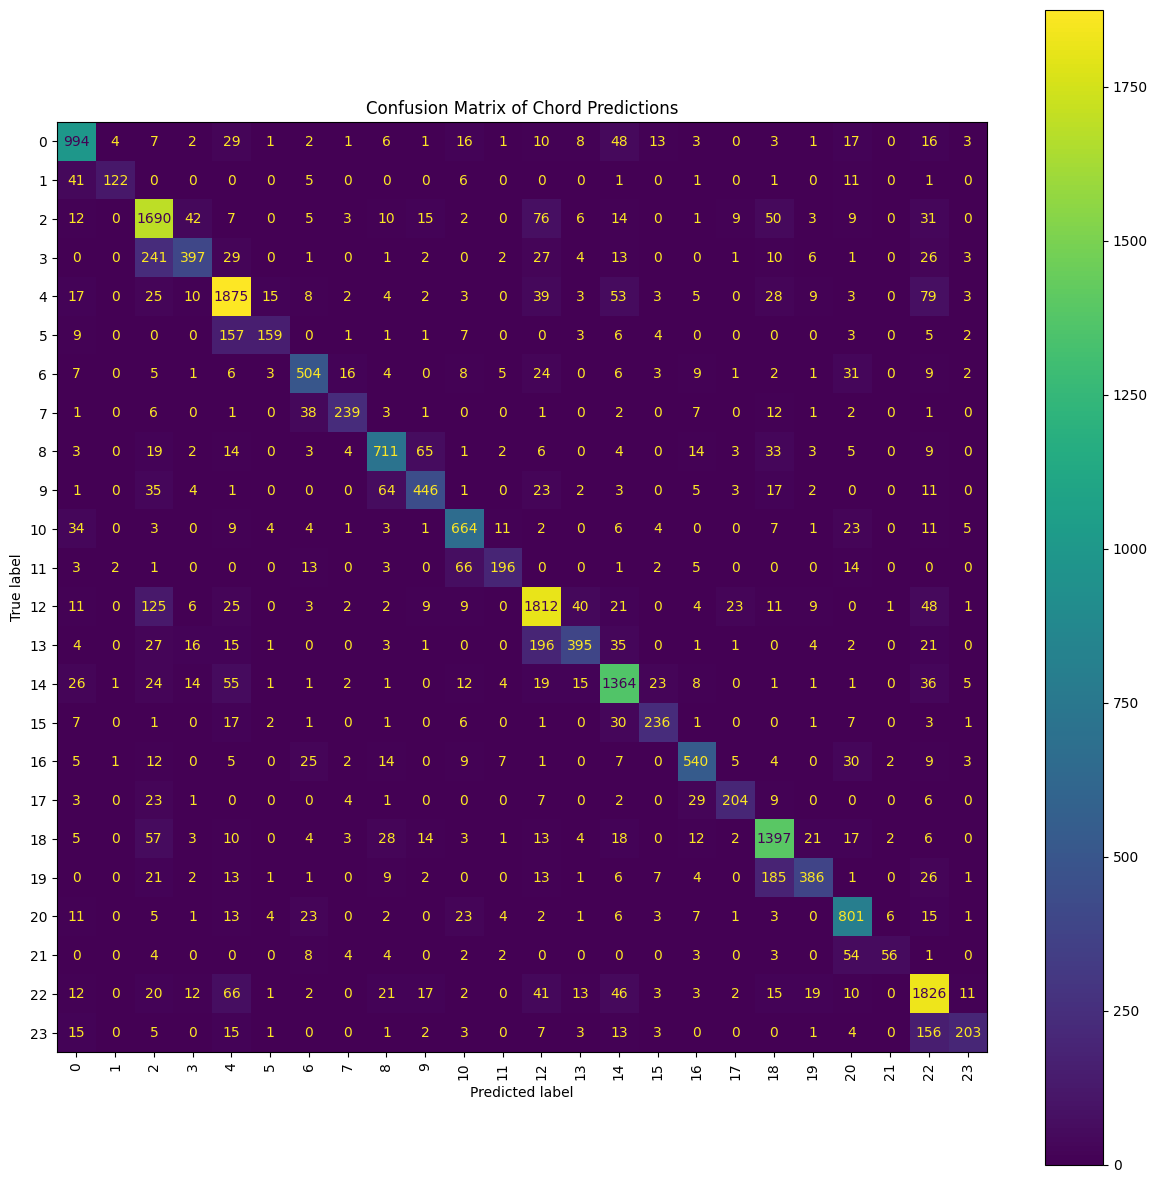

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix of Chord Predictions")
plt.show()

### Train Model - Decision Tree

In [6]:
# Create and train the model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, y_pred))

NameError: name 'X_train' is not defined

### Confusion Matrix - Decision Tree

## Analysis

### Results
Originally, I was getting precision values varying in the range from 0.50 to 0.90.

Then, I realized that enharmonic notes were messing up the data. Harmonically, C#maj is the same as Dbmaj, and had to be treated as such when training. This also gave more data on each category, giving chords without many examples like D#min twice as many examples after being combined with Ebmin.

After that, precision rose for all categories to a range of 0.75 to 0.95. 

### Use Case
This will be most useful in times where you know a chord change happens, but can't identify it. 